<a href="https://colab.research.google.com/github/yoyogo96/AI_Friends/blob/master/Top_acc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
# import tensorflow.keras as keras
import keras
from tensorflow.keras import layers, models
from tqdm import tqdm

!pip install livelossplot
from google.colab import drive 
drive.mount('/content/gdrive')

!nvidia-smi



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Sat Jan  2 14:42:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----

In [2]:
# read = np.loadtxt('./top_acc_data_ntry_100.csv', delimiter=',', dtype=np.float32)

In [3]:
## 데이터 나누기
import os

n_data = 1000
nelx = 32
nely = 32
start_slice = 5  ## 슬라이스 시작 시점
window = 5 # 몇개 iteration 사용할 것인지?

X = []
Y = []


from google.colab import files
# uploaded = files.upload()


# !rm -f X.npy 
if os.path.isfile('X.npy') == False:
    for i in tqdm(range(n_data)):
        # de_his = np.load('./data/design_%d.npy'%(i))
        de_his = np.load('/content/gdrive/My Drive/Data/to_data/design_%d.npy'%(i))
    #     dc_his = np.load('./data/dc_%d.npy'%(i))
    #     print(de_his.shape)
        max_iter = de_his.shape[0]
        for j in range(max_iter-start_slice-window):
            Y.append(de_his[-1,:,:])
            X.append(de_his[start_slice+j:start_slice+j+window])
        
    Y=np.array(Y)
    X=np.array(X)
    X = np.transpose(X, (0, 2, 3, 1))
    np.save('X',X)
    np.save('Y',Y)

else:
    print('load exsting training file')
    X = np.load('X.npy')
    Y = np.load('Y.npy')

print(Y.shape)
print(X.shape)


load exsting training file
(35374, 32, 32)
(35374, 32, 32, 5)


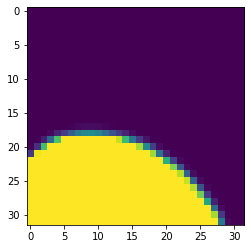

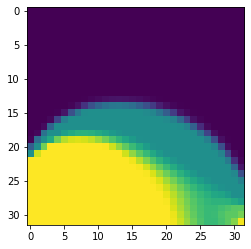

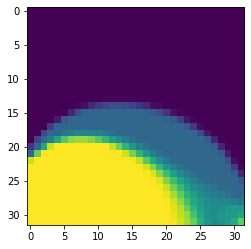

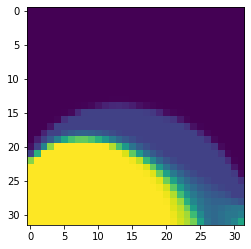

In [4]:
plt.imshow(Y[0])
plt.show()

plt.imshow(X[0,:,:,0])
plt.show()
plt.imshow(X[0,:,:,1])
plt.show()
plt.imshow(X[0,:,:,2])

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.2, 
                                                    shuffle=False, 
                                                    random_state=1004)


In [6]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Dropout, Lambda, BatchNormalization, Activation
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
# import keras
# from tensorflow import keras
# from tensorflow.keras import layers


def conv_bn(x, filters, bn,activation):
    x = Conv2D(filters, kernel_size=3, padding="same")(x)
    if bn==True:
      # x = layers.BatchNormalization(momentum=0.0)(x)
      x = BatchNormalization()(x)
    return Activation(activation)(x)

activation = 'elu'
kernel_initializer='he_normal'
padding='same'
filters = 64
bn = True

def generate_model():
    inputs = Input((nelx, nely, window))
    c1 = conv_bn(inputs, filters, bn, activation)
    c1 = conv_bn(c1, filters, bn, activation)
    p1 = MaxPooling2D((2,2))(c1)
    
    c2 = conv_bn(p1, filters*2, bn, activation)
    c2 = conv_bn(c2, filters*2, bn, activation)
    p2 = MaxPooling2D((2,2))(c2)
     
    c3 = conv_bn(p2, filters*4, bn, activation)
    c3 = conv_bn(c3, filters*4, bn, activation)
    u4 = Conv2DTranspose(filters*2, (2, 2), strides=(2, 2), padding='same')(c3)  
    u4 = concatenate([u4, c2])
    
    c4 = conv_bn(u4, filters*2, bn, activation)
    c4 = conv_bn(c4, filters*2, bn, activation)
    
    u5 = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(c4)  
    u5 = concatenate([u5, c1])
    c5 = conv_bn(u5, filters, bn, activation)
    c5 = conv_bn(u5, 16, bn, activation)
    output = conv_bn(u5, 1, False, 'sigmoid')
    
    model = Model(inputs=[inputs], outputs=[output])
    model.compile(optimizer='adam', loss='mae')
    model.summary()
    
    return model


model = generate_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 5)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   2944        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

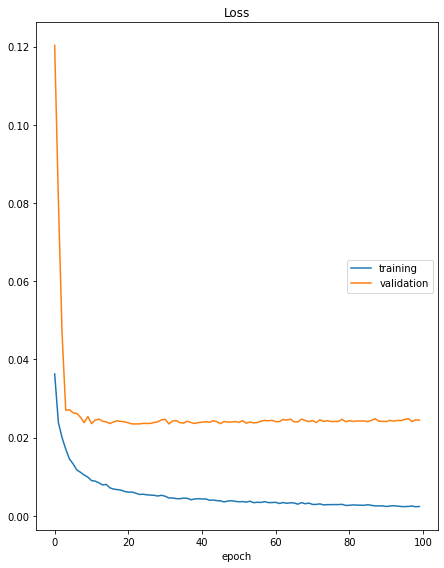

Loss
	training         	 (min:    0.002, max:    0.036, cur:    0.002)
	validation       	 (min:    0.024, max:    0.120, cur:    0.024)
time : 359.7075526714325


In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras

import time
start = time.time()  # 시작 시간 저장

MODEL_SAVE_FOLDER_PATH = './model/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)

model_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'
best_save = ModelCheckpoint('best_m.hdf5', save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='loss', patience=200)

history = model.fit(X_train, Y_train, epochs=100,
                  batch_size=128,
                  shuffle=True,
                  validation_split=0.2,
                  verbose = 0,
                  callbacks=[best_save, PlotLossesKeras(), early_stop])

print("time :", time.time() - start) 

In [9]:
model = load_model('best_m.hdf5')

model.evaluate(X_test, Y_test)
pred = model.evaluate(X_test)




222/222 [==============================] - 0s 1ms/step - loss: 0.0000e+00
